# 2 Colour terms

In this notebook we match the 2MASS reference with the VISTA VIDEO catalogue in order to test the colour terms required to use 2MASS as a calibration catalogue. This notebook is entirely concerned with previously produced catalogues in order to understand how the 2MASS catalogues can be used to calibrate the VISTA imaging and photometry products. We will then compare to the resultant LSST pipeline catalogues. Since the brighter objects are more likely to be used as a reference due to the depth of the VISTA six exposure stacks and also more likely to be saturated in VISTA depending on exposure times we must take care to understand how offsets depend on magnitude.

We are comparing:

### The 2MASS JHKs Vega catalogues

The photometric solution is described here:

https://old.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html

We take the fluxes for a 0 magnitude object from here for the AB conversion. The colour terms to use these to estimate the VISTA magnitudes are taken from Gonzalez-Fernandez et al (2017?).


### The CASU VISTA catalogues 

These are taken from IRIS. We use the zero point from the header and take the 3 arcsecond aperture photometry with aperture corrections taken from the catalogue.

For comparison here. These are calculated using:

mag = header['MAZPT'] - 2.5 * log10(data['Aper_flux_3']/header['EXPTIME']) - header['APCOR3']

These should be AB magnitudes.

### The public VIDEO VISTA catalogues

These are the catalogues used by HELP and were provided by Matt Jarvis. These are described here:

https://github.com/H-E-L-P/dmu_products/tree/master/dmu0/dmu0_VISTA-VIDEO-private

We are comparing the 3 arcsec corrected aperture AB magnitudes.

### The updated VIDEO SExtractor catalogues

These private catalogues were produced in Oxford and provided by Rebecca Bowler. They contain 2 arcsec aperture magnitudes.

In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, vstack
import astropy.units as u

import os
from collections import OrderedDict
import yaml
import glob
import numpy as np

import matplotlib.pyplot as plt

from lsst.geom import degrees
import lsst.daf.persistence as dafPersist

import warnings
warnings.filterwarnings('ignore')

In [2]:
MASS_CAT = "../dmu0/dmu0_2MASS/data/fp_2mass.fp_psc_29182.tbl"
#VIDEO_CAT = "../dmu0/dmu0_VISTA/dmu0_VIDEO/data/VIDEO-all_2017-02-12_fullcat_errfix_XMM-LSS.fits"
VIDEO_CAT = "../dmu0/dmu0_VISTA/dmu0_VIDEO/data/VIDEO-all_2017-02-12_fullcat_errfix_v2_XMM-LSS.fits"
Y_TILE_CAT = "../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20120924/v20120924_00498_st_tl_cat.fits"
J_TILE_CAT = "../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121021/v20121021_00293_st_tl_cat.fits"
H_TILE_CAT = "../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00088_st_tl_cat.fits"
Ks_TILE_CAT = "../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20171027/v20171027_00133_st_tl_cat.fits"

OXFORD_HSC_I_CAT = "../dmu3/data/XMMFULL_DR2_MASKVISTA_HSC-I_2.0as_IRAC2.8as_2020_05_26.fits"
OXFORD_VISTA_Ks_CAT = "../dmu3/data/XMMFULL_DR2_MASKVISTA_Ks_2.0as_IRAC2.8as_2020_06_01.fits"



In [3]:
import logging
LOGGER = logging.getLogger(__name__)
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import Counter
from astropy.table import Table, Column, hstack, vstack
def merge_catalogues(cat_1, cat_2, racol_2, decol_2, radius=0.4*u.arcsec):
    """Merge two catalogues
    This function merges the second catalogue into the first one using the
    given radius to associate identical sources.  This function takes care to
    associate only one source of one catalogue to the other.  The sources that
    may be associated to various counterparts in the other catalogue are
    flagged as “maybe spurious association” with a true value in the
    flag_merged column.  If this column is present in the first catalogue, it's
    content is “inherited” during the merge.
    Parameters
    ----------
    cat_1: astropy.table.Table
        The table containing the first catalogue.  This is the master catalogue
        used during the merge.  If it has a “flag_merged” column it's content
        will be re-used in the flagging of the spurious merges.  This catalogue
        must contain a ‘ra’ and a ‘dec’ columns with the position in decimal
        degrees.
    cat_2: astropy.table.Table
        The table containing the second catalogue.
    racol_2: string
        Name of the column in the second table containing the right ascension
        in decimal degrees.
    decol_2: string
        Name of the column in the second table containing the declination in
        decimal degrees.
    radius: astropy.units.quantity.Quantity
        The radius to associate identical sources in the two catalogues.
    Returns
    -------
    astropy.table.Table
        The merged catalogue.
    """
    cat_1 = cat_1.copy()
    cat_2 = cat_2.copy()
    cat_1['ra'].unit = u.rad
    cat_1['dec'].unit = u.rad
    coords_1 = SkyCoord(cat_1['ra'], cat_1['dec'])

    
    cat_2[racol_2].unit = u.rad
    cat_2[decol_2].unit = u.rad
    coords_2 = SkyCoord(cat_2[racol_2], cat_2[decol_2])

    # Search for sources in second catalogue matching the sources in the first
    # one.
    idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)

    # We want to flag the possible mis-associations, i.e. the sources in each
    # catalogue that are associated to several sources in the other one, but
    # also all the sources that are associated to a problematic source in the
    # other catalogue (e.g. if two sources in the first catalogue are
    # associated to the same source in the second catalogue, they must be
    # flagged as potentially problematic).
    #
    # Search for duplicate associations
    toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
    toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
    # Flagging the sources associated to duplicates
    dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
    dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
    toflag_idx_1 = np.unique(np.concatenate(
        (toflag_idx_1, idx_1[dup_associated_in_idx1])
    ))
    toflag_idx_2 = np.unique(np.concatenate(
        (toflag_idx_2, idx_2[dup_associated_in_idx2])
    ))

    # Adding the flags to the catalogue.  In the second catalogue, the column
    # is named "flag_merged_2" and will be combined to the flag_merged column
    # one the merge is done.
    try:
        cat_1["flag_merged"] |= np.in1d(np.arange(len(cat_1), dtype=int),
                                        toflag_idx_1)
    except KeyError:
        cat_1.add_column(Column(
            data=np.in1d(np.arange(len(cat_1), dtype=int), toflag_idx_1),
            name="flag_merged"
        ))
    try:
        cat_2["flag_merged_2"] |= np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2)
    except KeyError:
        cat_2.add_column(Column(
            data=np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2),
            name="flag_merged_2"
        ))


    # Now that we have flagged the maybe spurious associations, we want to
    # associate each source of each catalogue to at most one source in the
    # other one.

    # We sort the indices by the distance to take the nearest counterparts in
    # the following steps.
    sort_idx = np.argsort(d2d)
    idx_1 = idx_1[sort_idx]
    idx_2 = idx_2[sort_idx]

    # These array will contain the indexes of the matching sources in both
    # catalogues.
    match_idx_1 = np.array([], dtype=int)
    match_idx_2 = np.array([], dtype=int)

    while len(idx_1) > 0:

        both_first_idx = np.sort(np.intersect1d(
            np.unique(idx_1, return_index=True)[1],
            np.unique(idx_2, return_index=True)[1],
        ))

        new_match_idx_1 = idx_1[both_first_idx]
        new_match_idx_2 = idx_2[both_first_idx]

        match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
        match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

        # We remove the matching sources in both catalogues.
        to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
        idx_1 = idx_1[~to_remove]
        idx_2 = idx_2[~to_remove]

    # Indices of un-associated object in both catalogues.
    unmatched_idx_1 = np.delete(np.arange(len(cat_1), dtype=int),match_idx_1)
    unmatched_idx_2 = np.delete(np.arange(len(cat_2), dtype=int),match_idx_2)

    # Sources only in cat_1
    only_in_cat_1 = cat_1[unmatched_idx_1]

    # Sources only in cat_2
    only_in_cat_2 = cat_2[unmatched_idx_2]
    # We are using the ra and dec columns from cat_2 for the position.
    only_in_cat_2[racol_2].name = "ra"
    only_in_cat_2[decol_2].name = "dec"

    # Merged table of sources in both catalogues.
    both_in_cat_1_and_cat_2 = hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
    # We don't need the positions from the second catalogue anymore.
    both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

    # Logging the number of rows
    LOGGER.info("There are %s sources only in the first catalogue",
                len(only_in_cat_1))
    LOGGER.info("There are %s sources only in the second catalogue",
                len(only_in_cat_2))
    LOGGER.info("There are %s sources in both catalogues",
                len(both_in_cat_1_and_cat_2))

    merged_catalogue = vstack([only_in_cat_1, both_in_cat_1_and_cat_2,
                               only_in_cat_2])

    # When vertically stacking the catalogues, some values in the flag columns
    # are masked because they did not exist in the catalogue some row originate
    # from. We must set them to the appropriate value.
    for colname in merged_catalogue.colnames:
        if 'flag' in colname:
            merged_catalogue[colname][merged_catalogue[colname].mask] = False

    # We combined the flag_merged flags
    merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
    merged_catalogue.remove_column('flag_merged_2')

    return merged_catalogue

In [4]:
def clean_table(table):
    """Take a table produced by a VO query and remove all empty columns
    
    Often many columns are empty and make the tables hard to read.
    The function also converts columsn that are objects to strings.
    Object columns prevent writing to fits.
    
    Inputs
    =======
    table,    Astropy.table.Table
        The input table
    
    Returns
    =======
    table,    Astropy.table.Table
         The modified table.
    
    """
    table = table.copy()
    if len(table) == 0:
        return table
    for col in table.colnames:
        #Remove empty columns
        try:
            if np.all(table[col].mask):
                print("Removing empty column: {}".format(col))
                table.remove_column(col)
                continue
        except AttributeError:
            print("{} is not a masked columns".format(col))
            
        #Get rid of column type object from VO queries
        if table[col].dtype == 'object':
            print("Converting column {} type from object to string".format(col) )
            table[col] = table[col].astype(str)
 
        #Get rid of unit '-' from some tables
        if table[col].unit == '-':
            print("Converting column {} unit from '-' to None".format(col) )
            table[col].unit = None   
            
        #replace masked floats with nans     
        if (table[col].dtype == 'float64') or (table[col].dtype == 'float32'):
            table[col].fill_value = np.nan
    
    table = table.filled()
            
    return table


### 2MASS

In [5]:
c_2mass = Table.read(MASS_CAT, format = 'ascii')


In [6]:
#c_2mass['ra'].name = 'v_ra'
#c_2mass['dec'].name = 'v_dec'
c_2mass['j_m'].name = 'j'
c_2mass['j_cmsig'].name = 'j_err'
c_2mass['h_m'].name = 'h'
c_2mass['h_cmsig'].name = 'h_err'
c_2mass['k_m'].name = 'ks'
c_2mass['k_cmsig'].name = 'ks_err'
c_2mass = c_2mass['ra', 'dec', 'j','j_err','h','h_err','ks','ks_err']
c_2mass['ra'].convert_unit_to(u.rad)
c_2mass['dec'].convert_unit_to(u.rad)


### HELP

In [7]:
imported_columns = OrderedDict({
        'ID':              'video_id', 
        'ALPHA_J2000':     'ra', 
        'DELTA_J2000':     'dec', 
    
        'J_CLASS_STAR':    'vista_stellarity', 
    
        'Y_MAG_APER_3':    'm_ap_vista_y', 
        'Y_MAGERR_APER_3': 'merr_ap_vista_y', 
        'Y_MAG_AUTO':      'm_vista_y', 
        'Y_MAGERR_AUTO':   'merr_vista_y',
    
        'J_MAG_APER_3':    'm_ap_vista_j', 
        'J_MAGERR_APER_3': 'merr_ap_vista_j', 
        'J_MAG_AUTO':      'm_vista_j', 
        'J_MAGERR_AUTO':   'merr_vista_j',
    
        'H_MAG_APER_3':    'm_ap_vista_h', 
        'H_MAGERR_APER_3': 'merr_ap_vista_h', 
        'H_MAG_AUTO':      'm_vista_h', 
        'H_MAGERR_AUTO':   'merr_vista_h',
  
        'K_MAG_APER_3':    'm_ap_vista_ks', 
        'K_MAGERR_APER_3': 'merr_ap_vista_ks', 
        'K_MAG_AUTO':      'm_vista_ks', 
        'K_MAGERR_AUTO':   'merr_vista_ks',

})


help_cat = Table.read(VIDEO_CAT
                      )[list(imported_columns)]
for column in imported_columns:
    help_cat[column].name = 'help_' + imported_columns[column]
help_cat['help_ra'].unit = u.deg
help_cat['help_dec'].unit = u.deg
help_cat['help_ra'].convert_unit_to(u.rad)
help_cat['help_dec'].convert_unit_to(u.rad)

### CASU Tiles

In [8]:
TILE_COLS = ['RA', 'DEC', 'Classification', 'Aper_flux_3', 'Aper_flux_3_err']

y_tile_cat = Table.read(Y_TILE_CAT)[TILE_COLS]
y_magzpt = fits.open(Y_TILE_CAT)[1].header['MAGZPT']
y_exptime = fits.open(Y_TILE_CAT)[1].header['EXPTIME']
y_apcor3 = fits.open(Y_TILE_CAT)[1].header['APCOR3']
y_tile_cat['m_ap_vista_y'] = y_magzpt - 2.5 * np.log10(y_tile_cat['Aper_flux_3']/y_exptime) - y_apcor3
y_tile_cat['merr_ap_vista_y'] = (2.5 / np.log(10))* (y_tile_cat['Aper_flux_3_err'] / y_tile_cat['Aper_flux_3'])
for c in y_tile_cat.colnames:
    y_tile_cat[c].name = 'y_tile_' + c
y_tile_cat['y_tile_RA'].unit = u.rad
y_tile_cat['y_tile_DEC'].unit = u.rad

j_tile_cat = Table.read(J_TILE_CAT)[TILE_COLS]
j_magzpt = fits.open(J_TILE_CAT)[1].header['MAGZPT']
j_exptime = fits.open(J_TILE_CAT)[1].header['EXPTIME']
j_apcor3 = fits.open(J_TILE_CAT)[1].header['APCOR3']
j_tile_cat['m_ap_vista_j'] = j_magzpt - 2.5 * np.log10(j_tile_cat['Aper_flux_3']/j_exptime) - j_apcor3
j_tile_cat['merr_ap_vista_j'] = (2.5 / np.log(10))* (j_tile_cat['Aper_flux_3_err'] / j_tile_cat['Aper_flux_3'])
for c in j_tile_cat.colnames:
    j_tile_cat[c].name = 'j_tile_' + c
j_tile_cat['j_tile_RA'].unit = u.rad
j_tile_cat['j_tile_DEC'].unit = u.rad

h_tile_cat = Table.read(H_TILE_CAT)[TILE_COLS]
h_magzpt = fits.open(H_TILE_CAT)[1].header['MAGZPT']
h_exptime = fits.open(H_TILE_CAT)[1].header['EXPTIME']
h_apcor3 = fits.open(H_TILE_CAT)[1].header['APCOR3']
h_tile_cat['m_ap_vista_h'] = h_magzpt - 2.5 * np.log10(h_tile_cat['Aper_flux_3']/h_exptime) - h_apcor3
h_tile_cat['merr_ap_vista_h'] = (2.5 / np.log(10))* (h_tile_cat['Aper_flux_3_err'] / h_tile_cat['Aper_flux_3'])
for c in h_tile_cat.colnames:
    h_tile_cat[c].name = 'h_tile_' + c
h_tile_cat['h_tile_RA'].unit = u.rad
h_tile_cat['h_tile_DEC'].unit = u.rad

ks_tile_cat = Table.read(Ks_TILE_CAT)[TILE_COLS]
ks_magzpt = fits.open(Ks_TILE_CAT)[1].header['MAGZPT']
ks_exptime = fits.open(Ks_TILE_CAT)[1].header['EXPTIME']
ks_apcor3 = fits.open(Ks_TILE_CAT)[1].header['APCOR3']
ks_tile_cat['m_ap_vista_ks'] = ks_magzpt - 2.5 * np.log10(ks_tile_cat['Aper_flux_3']/ks_exptime) - ks_apcor3
ks_tile_cat['merr_ap_vista_ks'] = (2.5 / np.log(10))* (ks_tile_cat['Aper_flux_3_err'] / ks_tile_cat['Aper_flux_3'])
for c in ks_tile_cat.colnames:
    ks_tile_cat[c].name = 'ks_tile_' + c
ks_tile_cat['ks_tile_RA'].unit = u.rad
ks_tile_cat['ks_tile_DEC'].unit = u.rad

In [9]:
y_tile_cat[:5]

y_tile_RA,y_tile_DEC,y_tile_Classification,y_tile_Aper_flux_3,y_tile_Aper_flux_3_err,y_tile_m_ap_vista_y,y_tile_merr_ap_vista_y
rad,rad,Flag,ADU,ADU,ADU,ADU
float32,float32,float32,float32,float32,float32,float32
0.62322336,-0.07111973,1.0,569.2501,29.788216,19.276276,0.056815345
0.6239339,-0.071119815,1.0,1063.238,31.357847,18.597958,0.03202138
0.62275827,-0.071126156,-1.0,812.31604,30.535154,18.89022,0.04081308
0.62246937,-0.07112859,1.0,435.99716,29.345795,19.565826,0.07307798
0.6212868,-0.07113493,1.0,220.86967,28.661175,20.304195,0.14089066


In [ ]:

TEST_LIMS = {
    'ra_min':np.min(y_tile_cat['y_tile_RA']),
    'ra_max':np.max(y_tile_cat['y_tile_RA']),
    'dec_min':np.min(y_tile_cat['y_tile_DEC']),
    'dec_max':np.max(y_tile_cat['y_tile_DEC']),
}

### Oxford Ks Selected

In [ ]:
imported_columns = OrderedDict({
        'ID_se':              'id', 
        'RA':     'ra', 
        'DEC':     'dec', 
    
        #'J_CLASS_STAR':    'vista_stellarity', 
     
        #HSC GRIZY?
        'flux_Y':    'f_ap_vista_y', 
        'err_Y': 'ferr_ap_vista_y', #Flux error? ~E-30

    
        'flux_J':    'f_ap_vista_j', 
        'err_J': 'ferr_ap_vista_j', 

    
        'flux_H':    'f_ap_vista_h', 
        'err_H': 'ferr_ap_vista_h', 

  
        'flux_Ks':    'f_ap_vista_ks', 
        'err_Ks': 'ferr_ap_vista_ks', 


})


oxford_ks_cat = Table.read(OXFORD_VISTA_Ks_CAT
                      )[list(imported_columns)]
for column in imported_columns:
    oxford_ks_cat[column].name = 'oxford_ks_' + imported_columns[column]
    
for col in oxford_ks_cat.colnames:
oxford_ks_cat['oxford_ks_ra'].unit = u.deg
oxford_ks_cat['oxford_ks_dec'].unit = u.deg
oxford_ks_cat['oxford_ks_ra'].convert_unit_to(u.rad)
oxford_ks_cat['oxford_ks_dec'].convert_unit_to(u.rad)

### Oxford HSC-I Selected

## Merge the catalogues

We use 0.4 arcsec match starting with 2MASS. This should be low enough to exclude too many false matches but may remove some fraction of good matches.

In [10]:

merge  = merge_catalogues( c_2mass, help_cat, 'help_ra', 'help_dec', radius=0.4*u.arcsec)
merge  = merge_catalogues( merge, y_tile_cat, 'y_tile_RA', 'y_tile_DEC', radius=0.4*u.arcsec)
merge  = merge_catalogues( merge, j_tile_cat, 'j_tile_RA', 'j_tile_DEC', radius=0.4*u.arcsec)
merge  = merge_catalogues( merge, h_tile_cat, 'h_tile_RA', 'h_tile_DEC', radius=0.4*u.arcsec)
merge  = merge_catalogues( merge, ks_tile_cat, 'ks_tile_RA', 'ks_tile_DEC', radius=0.4*u.arcsec)
merge = clean_table(merge)


In [11]:
c0=1.827+0.011 

c1=0.006
c2=0.0
primary = merge['ks']
secondary = merge['j']
merge['corrected_m_2mass_ks'] = primary + c0 + c1*(primary - secondary)



In [12]:
#These taken from http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html
# The AB zero point is 3631 Jy
j_2mass_to_ab = 2.5 * np.log10(3631/1594)
h_2mass_to_ab = 2.5 * np.log10(3631/1024)
ks_2mass_to_ab = 2.5 * np.log10(3631/666.7)
print(j_2mass_to_ab,h_2mass_to_ab,ks_2mass_to_ab)


0.8938448296319969 1.3743157306827007 1.840239484468321


In [13]:
 merge[:10]

ra,dec,j,j_err,h,h_err,ks,ks_err,flag_merged,help_video_id,help_vista_stellarity,help_m_ap_vista_y,help_merr_ap_vista_y,help_m_vista_y,help_merr_vista_y,help_m_ap_vista_j,help_merr_ap_vista_j,help_m_vista_j,help_merr_vista_j,help_m_ap_vista_h,help_merr_ap_vista_h,help_m_vista_h,help_merr_vista_h,help_m_ap_vista_ks,help_merr_ap_vista_ks,help_m_vista_ks,help_merr_vista_ks,y_tile_Classification,y_tile_Aper_flux_3,y_tile_Aper_flux_3_err,y_tile_m_ap_vista_y,y_tile_merr_ap_vista_y,j_tile_Classification,j_tile_Aper_flux_3,j_tile_Aper_flux_3_err,j_tile_m_ap_vista_j,j_tile_merr_ap_vista_j,h_tile_Classification,h_tile_Aper_flux_3,h_tile_Aper_flux_3_err,h_tile_m_ap_vista_h,h_tile_merr_ap_vista_h,ks_tile_Classification,ks_tile_Aper_flux_3,ks_tile_Aper_flux_3_err,ks_tile_m_ap_vista_ks,ks_tile_merr_ap_vista_ks,corrected_m_2mass_ks
rad,rad,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,,,,,,Flag,ADU,ADU,ADU,ADU,Flag,ADU,ADU,ADU,ADU,Flag,ADU,ADU,ADU,ADU,Flag,ADU,ADU,ADU,ADU,mag
float64,float64,float64,float64,float64,float64,float64,float64,bool,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64
0.5759674147109737,-0.10872003231193826,15.391,0.063,15.075,0.1,15.228,0.195,False,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,17.065022
0.5759691774935183,-0.08066281738857821,14.624,0.03,13.989,0.034,13.836,0.042,False,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,15.669272
0.5759705388503349,-0.1205944845976368,13.46,0.026,13.174,0.027,13.017,0.037,False,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,14.852341999999998
0.5759754606788254,-0.053491095261217494,16.012,0.074,15.453,0.103,15.087,0.126,False,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,16.91945
0.5759785499116015,-0.0758032971522504,16.515,0.148,15.655,0.139,15.173,nan,False,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,17.002948
0.5759796843756153,-0.08096795330170439,16.196,0.078,15.626,0.127,15.425,0.173,False,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,17.258374000000003
0.5759806268534113,-0.07188642924492472,14.422,0.021,13.895,0.02,13.729,0.044,False,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,15.562841999999998
0.5759856359483645,-0.07804100123952486,15.385,0.039,14.754,0.059,14.546,0.077,False,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,16.378966000000002


Text(0.5, 0, 'CASU Tile Ks mags [mag]')

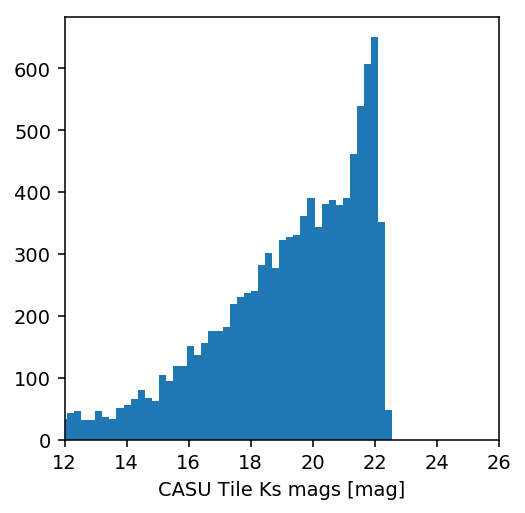

In [14]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks_tile_m_ap_vista_ks'] > 0) & (merge['ks_tile_Classification'] == -1)
plt.hist(merge[m]['ks_tile_m_ap_vista_ks'] , bins=50)

plt.xlim([12,26])
#plt.ylim([0,450])
plt.xlabel('CASU Tile Ks mags [mag]')

Text(0.5, 0, 'HELP Ks mags [mag]')

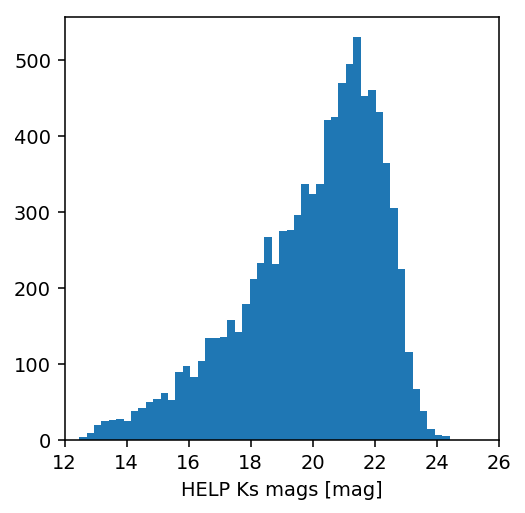

In [28]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['help_m_ap_vista_ks'] < 30) & (merge['ks_tile_Classification'] == -1)
plt.hist(merge[m]['help_m_ap_vista_ks'] , bins=50)

plt.xlim([12,26])
#plt.ylim([0,450])
plt.xlabel('HELP Ks mags [mag]')

Mean offset = -0.13773541469281664


Text(0, 0.5, '2MASS AB - HELP VIDEO Ks AB mags [mag]')

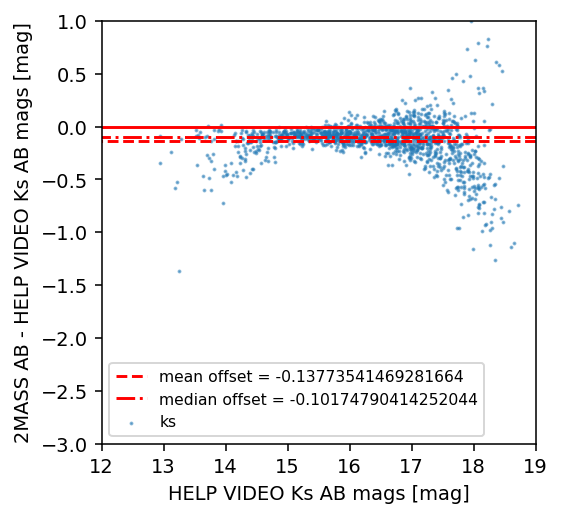

In [15]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (
    (merge['ks'] > 0) 
    & (merge['help_m_ap_vista_ks']<30) 
    & (merge['ks_tile_Classification'] == -1) 
    & (merge['help_vista_stellarity']>0.9)
)
mean_offset = np.mean((merge[m]['ks'] + ks_2mass_to_ab) - merge[m]['help_m_ap_vista_ks'])
median_offset = np.median((merge[m]['ks'] + ks_2mass_to_ab) - merge[m]['help_m_ap_vista_ks'])
print("Mean offset = {}".format(mean_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r',  label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.scatter(merge[m]['help_m_ap_vista_ks'],   (merge[m]['ks'] + ks_2mass_to_ab) - merge[m]['help_m_ap_vista_ks'], 
            s=1,alpha=0.5)
plt.xlabel('HELP VIDEO Ks AB mags [mag]')
plt.plot([0,26],[0,0], c='r')

plt.legend( prop={'size': 8})
plt.xlim([12,19])
plt.ylim([-3,1])
plt.ylabel('2MASS AB - HELP VIDEO Ks AB mags [mag]')



Mean offset = -0.18943455098407813
Median offset = -0.11451577734375107


Text(0, 0.5, '2MASS Corrected - HELP VIDEO Ks AB mags [mag]')

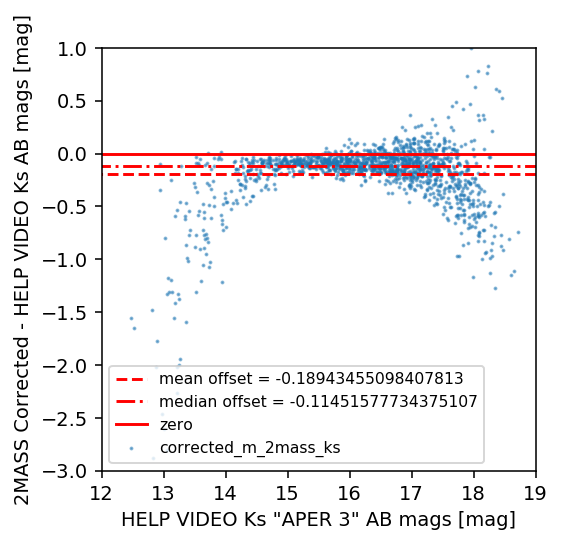

In [16]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (
    (merge['ks'] > 0) 
    & (merge['help_m_ap_vista_ks']<30) 
    & (merge['ks_tile_Classification'] == -1) 
    #& (merge['help_vista_stellarity']>0.9)
)
mean_offset = np.mean(merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks']) 
median_offset = np.median(merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks'])
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[m]['help_m_ap_vista_ks'],   merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks'],
            s=1,alpha=0.5)

plt.legend( prop={'size': 8})
plt.xlim([12,19])
plt.ylim([-3,1.])
plt.xlabel('HELP VIDEO Ks "APER 3" AB mags [mag]')
plt.ylabel('2MASS Corrected - HELP VIDEO Ks AB mags [mag]')


Mean offset = -0.14409224144301694
Median offset = -0.10809696417236303


Text(0, 0.5, '2MASS Corrected - HELP VIDEO Ks AB mags [mag]')

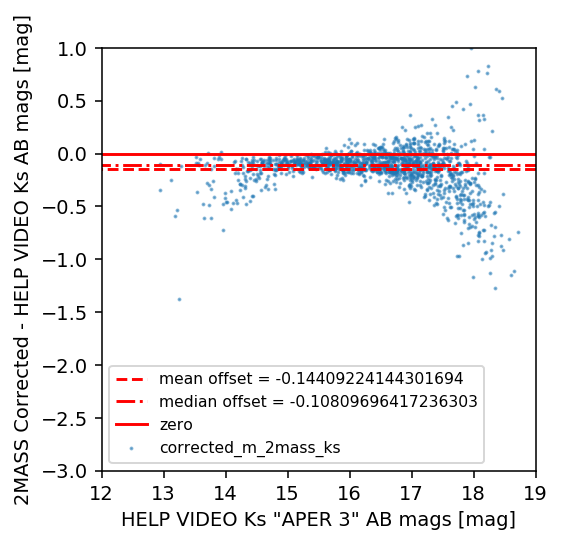

In [17]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (
    (merge['ks'] > 0) 
    & (merge['help_m_ap_vista_ks']<30) 
    & (merge['ks_tile_Classification'] == -1) 
    & (merge['help_vista_stellarity']>0.9)
)
mean_offset = np.mean(merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks']) 
median_offset = np.median(merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks'])
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[m]['help_m_ap_vista_ks'],   merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks'],
            s=1,alpha=0.5)

plt.legend( prop={'size': 8})
plt.xlim([12,19])
plt.ylim([-3,1.])
plt.xlabel('HELP VIDEO Ks "APER 3" AB mags [mag]')
plt.ylabel('2MASS Corrected - HELP VIDEO Ks AB mags [mag]')


Text(0.5, 0, '2MASS Corrected - HELP VIDEO Ks AB mags [mag]')

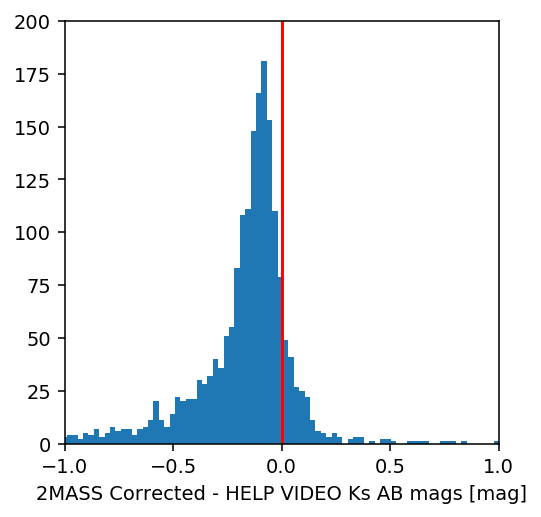

In [18]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['j'] > 0) & (merge['help_m_ap_vista_ks']<30)
plt.hist(merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks'], bins=200)
plt.vlines(0, 0,1000, colors='r')
plt.xlim([-1,1])
plt.ylim([0,200])
plt.xlabel('2MASS Corrected - HELP VIDEO Ks AB mags [mag]')

Text(0.5, 0, '2MASS Corrected (Ks<12) - HELP VIDEO Ks AB mags [mag]')

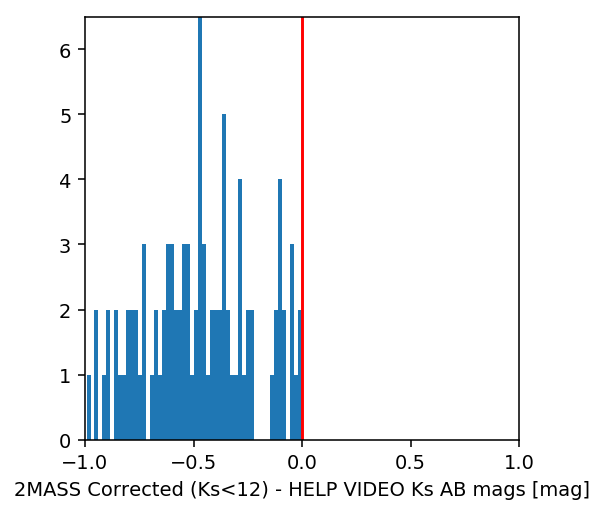

In [19]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks'] <12) & (merge['help_m_ap_vista_ks']<30)
plt.hist(merge[m]['corrected_m_2mass_ks'] - merge[m]['help_m_ap_vista_ks'], bins=200)
plt.vlines(0, 0,7, colors='r')
plt.xlim([-1,1])
plt.ylim([0,6.5])
plt.xlabel('2MASS Corrected (Ks<12) - HELP VIDEO Ks AB mags [mag]')

Mean offset = -0.19333988263218643
Median offset = -0.11741913064398446


Text(0, 0.5, '2MASS AB - HELP VIDEO Ks AB mags [mag]')

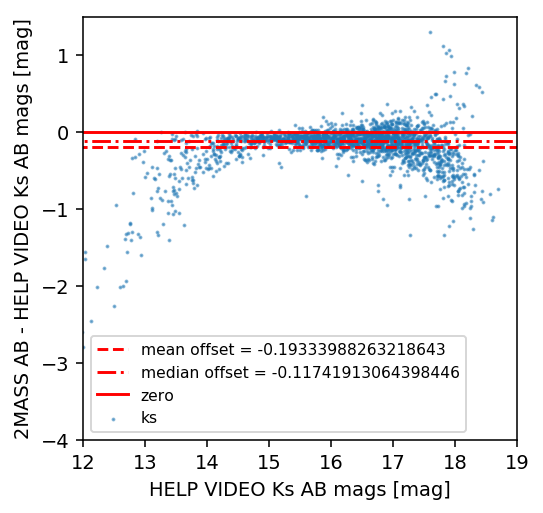

In [20]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks'] > 0) &(merge['help_m_ap_vista_ks'] <30)

plt.scatter(merge[m]['help_m_vista_ks'],   merge[m]['ks'] + ks_2mass_to_ab - merge[m]['help_m_ap_vista_ks'], 
            s=1,alpha=0.5)

mean_offset = np.mean(merge[m]['ks'] + ks_2mass_to_ab  - merge[m]['help_m_ap_vista_ks'])
median_offset = np.median(merge[m]['ks'] + ks_2mass_to_ab  - merge[m]['help_m_ap_vista_ks'])
print("Mean offset = {}".format(mean_offset))

print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')


plt.legend( prop={'size': 8})
plt.xlim([12,19])
plt.ylim([-4,1.5])
plt.xlabel('HELP VIDEO Ks AB mags [mag]')
plt.ylabel('2MASS AB - HELP VIDEO Ks AB mags [mag]')

Mean offset = -0.9612433314323425
Median offset = -0.9248533248901367


Text(0, 0.5, 'CASU Tile - HELP AB mags [mag]')

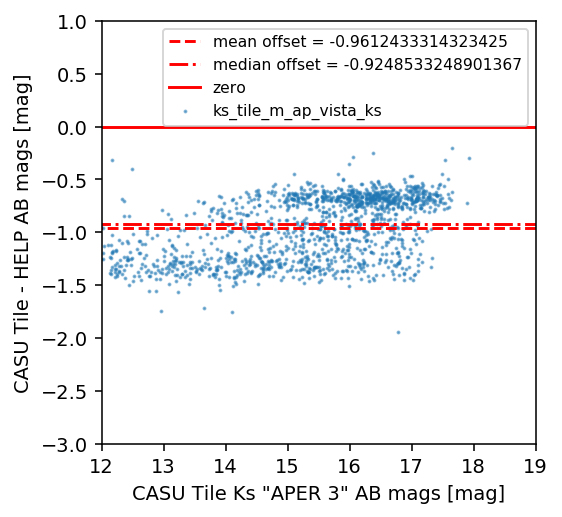

In [21]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks'] > 0) & (merge['help_m_ap_vista_ks']<30) & (merge['ks_tile_Classification'] == -1)
mean_offset = np.mean(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['help_m_ap_vista_ks']) 
median_offset = np.median(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['help_m_ap_vista_ks'])
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[m]['ks_tile_m_ap_vista_ks'],   merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['help_m_ap_vista_ks'],
            s=1,alpha=0.5)

plt.legend( prop={'size': 8})
plt.xlim([12,19])
plt.ylim([-3,1.])
plt.xlabel('CASU Tile Ks "APER 3" AB mags [mag]')
plt.ylabel('CASU Tile - HELP AB mags [mag]')

Text(0.5, 0, 'CASU - HELP VIDEO Ks AB mags [mag]')

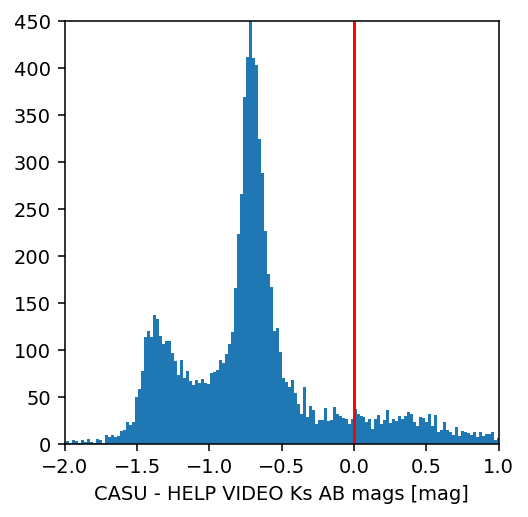

In [22]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks_tile_m_ap_vista_ks'] > 0) & (merge['ks_tile_Classification'] == -1)& (merge['help_m_ap_vista_ks']<30)
plt.hist(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['help_m_ap_vista_ks'], bins=200)
plt.vlines(0, 0,1000, colors='r')
plt.xlim([-2,1])
plt.ylim([0,450])
plt.xlabel('CASU - HELP VIDEO Ks AB mags [mag]')

Mean offset = -0.7652244478627418
Median offset = -0.7415097032470683


Text(0, 0.5, 'CASU Tile - 2MASS corrected AB mags [mag]')

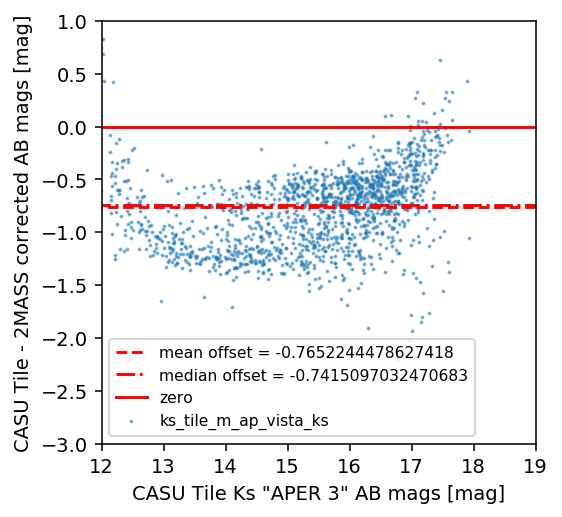

In [23]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks'] > 0) & (merge['corrected_m_2mass_ks']<30) & (merge['ks_tile_Classification'] == -1)
mean_offset = np.mean(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['corrected_m_2mass_ks']) 
median_offset = np.median(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['corrected_m_2mass_ks'])
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[m]['ks_tile_m_ap_vista_ks'],   merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['corrected_m_2mass_ks'],
            s=1,alpha=0.5)

plt.legend( prop={'size': 8})
plt.xlim([12,19])
plt.ylim([-3,1.])
plt.xlabel('CASU Tile Ks "APER 3" AB mags [mag]')
plt.ylabel('CASU Tile - 2MASS corrected AB mags [mag]')

Mean offset = -0.7652244478627418
Median offset = -0.7415097032470683


Text(0, 0.5, 'CASU Tile - 2MASS corrected AB mags [mag]')

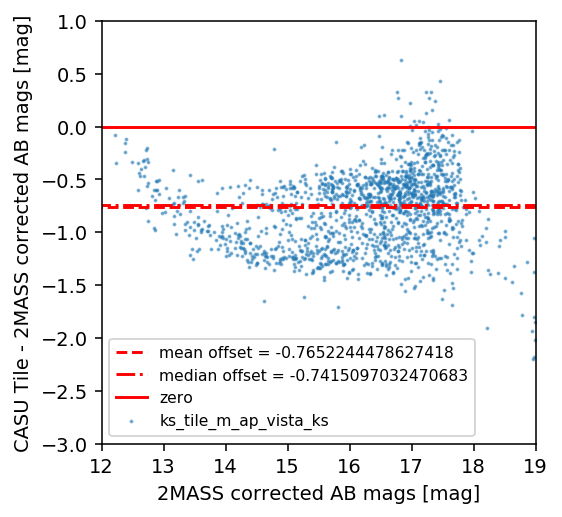

In [24]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks'] > 0) & (merge['corrected_m_2mass_ks']<30) & (merge['ks_tile_Classification'] == -1)
mean_offset = np.mean(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['corrected_m_2mass_ks']) 
median_offset = np.median(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['corrected_m_2mass_ks'])
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[m]['corrected_m_2mass_ks'],   merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['corrected_m_2mass_ks'],
            s=1,alpha=0.5)

plt.legend( prop={'size': 8})
plt.xlim([12,19])
plt.ylim([-3,1.])
plt.xlabel('2MASS corrected AB mags [mag]')
plt.ylabel('CASU Tile - 2MASS corrected AB mags [mag]')

Mean offset = -0.7715091161694467
Median offset = -0.7478839317949806


Text(0, 0.5, 'CASU Tile - 2MASS AB mags [mag]')

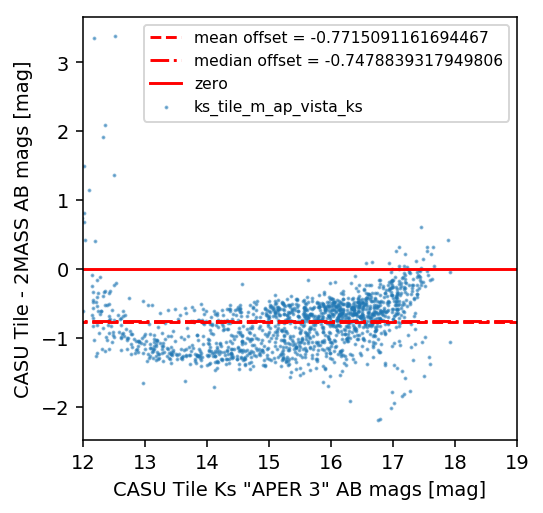

In [25]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks'] > 0) & (merge['corrected_m_2mass_ks']<30) & (merge['ks_tile_Classification'] == -1)
mean_offset = np.mean(merge[m]['ks_tile_m_ap_vista_ks'] - (merge[m]['ks'] + ks_2mass_to_ab) )
median_offset = np.median(merge[m]['ks_tile_m_ap_vista_ks'] - (merge[m]['ks'] + ks_2mass_to_ab))
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[m]['ks_tile_m_ap_vista_ks'],   merge[m]['ks_tile_m_ap_vista_ks'] - (merge[m]['ks'] + ks_2mass_to_ab),
            s=1,alpha=0.5)

plt.legend( prop={'size': 8})
plt.xlim([12,19])
#plt.ylim([-3,1.])
plt.xlabel('CASU Tile Ks "APER 3" AB mags [mag]')
plt.ylabel('CASU Tile - 2MASS AB mags [mag]')

Text(0.5, 0, 'CASU - 2MASS corrected Ks AB mags [mag]')

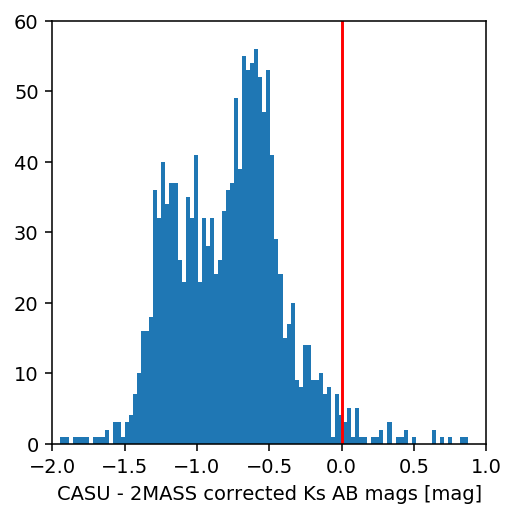

In [26]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (merge['ks'] > 0) & (merge['corrected_m_2mass_ks']<30) & (merge['ks_tile_Classification'] == -1)
plt.hist(merge[m]['ks_tile_m_ap_vista_ks'] - merge[m]['corrected_m_2mass_ks'], bins=200)
plt.vlines(0, 0,1000, colors='r')
plt.xlim([-2,1])
plt.ylim([0,60])
plt.xlabel('CASU - 2MASS corrected Ks AB mags [mag]')